#Dogs Vs Cats Classifier in Keras with Transfer Learning

# 1 - Import Libraries

## 1.1 - Setup

In [0]:
print('-'*30)
import sys 
print("Python version: {}". format(sys.version))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))

import tensorflow as tf
print("tensorflow version: {}". format(tf.__version__))

import warnings
warnings.filterwarnings('ignore')
print('-'*30)

------------------------------
Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
NumPy version: 1.18.4
pandas version: 1.0.3
matplotlib version: 3.2.1
tensorflow version: 2.2.0
------------------------------


## 1.2 - Modelling Libraries

In [0]:
#Image preprocessing
from tensorflow.keras.preprocessing import image

#Models and Layers
from tensorflow.keras.models import Model
from tensorflow.keras import layers

#Convolutional Neural Networks for Transfer Learning
from tensorflow.keras.applications import mobilenet

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#Others libraries
import math, random 
import os, shutil




#2 - Load the data

## 2 - 1 Mounting Google Drive locally

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/dogs-vs-cats')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/dogs-vs-cats'

In [0]:
#!unzip -uq 'datasets/train.zip' -d 'datasets/'
#!unzip -uq 'datasets/test.zip' -d 'datasets/'

## 2 - 2 Organize the data

In [0]:
%rm -r data
os.makedirs('./data/train/cat')
os.makedirs('./data/train/dog')
os.makedirs('./data/val/cat')
os.makedirs('./data/val/dog')

In [0]:
NB_SAMPLES = 5000

filenames = os.listdir('datasets/train')
filenames.sort()
random.seed(42)

cat_files = random.sample(filenames[:12500], k = NB_SAMPLES)
dog_files = random.sample(filenames[12500:], k = NB_SAMPLES)

# train set
for i in range(0, int(NB_SAMPLES/2)):
    shutil.move(os.path.join('./datasets/train', cat_files[i]), os.path.join('./data/train/cat', cat_files[i]))
    shutil.move(os.path.join('./datasets/train', dog_files[i]), os.path.join('./data/train/dog', dog_files[i]))

# validation set
for i in range(int(NB_SAMPLES/2), NB_SAMPLES):
    shutil.move(os.path.join('./datasets/train', cat_files[i]), os.path.join('./data/val/cat', cat_files[i]))
    shutil.move(os.path.join('./datasets/train', dog_files[i]), os.path.join('./data/val/dog', dog_files[i]))
    

## 2 - 3 Prepare the data for deep learning algorithms (data augmentation)

In [0]:
NB_SAMPLES = 5000
TRAIN_SAMPLES = NB_SAMPLES
VALIDATION_SAMPLES = NB_SAMPLES
IMG_WIDTH,IMG_HEIGHT = 224, 224
NUM_CLASSES = 2
BATCH_SIZE = 64

In [0]:
train_datagen = image.ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input, 
                                   rotation_range=20, width_shift_range=0.2, 
                                   height_shift_range=0.2, zoom_range=0.2)
val_datagen = image.ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

In [0]:
train_generator = train_datagen.flow_from_directory('./data/train/', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle=True, 
                                                    seed=42, 
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory( './data/val/', 
                                                       target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                       batch_size=64, 
                                                       shuffle=False, 
                                                       class_mode='categorical')

Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 3 - Modeling 

In [0]:
def model_maker():
    base_model = mobilenet.MobileNet(include_top=False, 
                           input_shape = (IMG_WIDTH, IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = layers.GlobalAveragePooling2D()(custom_model) 
    custom_model = layers.Dense(64, activation='relu')(custom_model) 
    custom_model = layers.Dropout(0.5)(custom_model)
    predictions  = layers.Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

#4 - Train the Model

In [0]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])
num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)
model.fit_generator(train_generator, 
                    steps_per_epoch = num_steps, 
                    epochs=20, 
                    validation_data = validation_generator, 
                    validation_steps = num_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
79/79 [==============================] - 439s 6s/step - loss: 0.2065 - acc: 0.9190 - val_loss: 0.0611 - val_acc: 0.9790
Epoch 2/20
79/79 [==============================] - 438s 6s/step - loss: 0.0914 - acc: 0.9670 - val_loss: 0.0567 - val_acc: 0.9792
Epoch 3/20
79/79 [==============================] - 437s 6s/step - loss: 0.0782 - acc: 0.9692 - val_loss: 0.0462 - val_acc: 0.9830
Epoch 4/20
79/79 [==============================] - 437s 6s/step - loss: 0.0760 - acc: 0.9704 - val_loss: 0.0437 - val_acc: 0.9840
Epoch 5/20
79/79 [==============================] - 435s 6s/step - loss: 0.0706 - acc: 0.9724 - val_loss: 0.0479 - val_acc: 0.9822
Epoch 6/20
79/79 [==============================] - 433s 5s/step - loss: 0.0625 - acc: 0.9752 - val_loss: 0.0406 - val_acc: 0.9852
Epoch 7/20
79/79 [==============================] - 432s 5s/step - loss: 0.0582 - acc: 0.9768 - val_loss: 0.0564 - val_acc: 0.9802
Epoch 8

In [0]:
model.save('model.h5')

#Analyzing the Results

In [0]:
from tensorflow.keras.models import load_model 
model = load_model('model.h5')

In [0]:
predictions = model.predict(validation_generator)

In [0]:
predictions

In [0]:
ground_truth = validation_generator.classes
# prediction_dic is a dict with index, prediction, ground truth
prediction_dic = {}
for index, val in enumerate(predictions):
      # get argmax index
      index_of_highest_probability = np.argmax(val) 
      value_of_highest_probability = val[index_of_highest_probability] 
      prediction_dic[index] = [value_of_highest_probability, index_of_highest_probability, ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_dic)

In [0]:
def get_dogs_images(prediction_dic, n=10, highest_probability=True, correct_predictions=True):
  

In [0]:
#prediction_table

In [0]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)

In [0]:
filenames = validation_generator.filenames
def display(sorted_indices, message):
  similar_image_paths = [] 
  distances = []
  for name, value in sorted_indices:
    [probability, predicted_index, gt] = value 
    similar_image_paths.append('./data/val/' + filenames[name]) 
    distances.append(probability)
  plot_images(similar_image_paths, distances, message)

In [0]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]


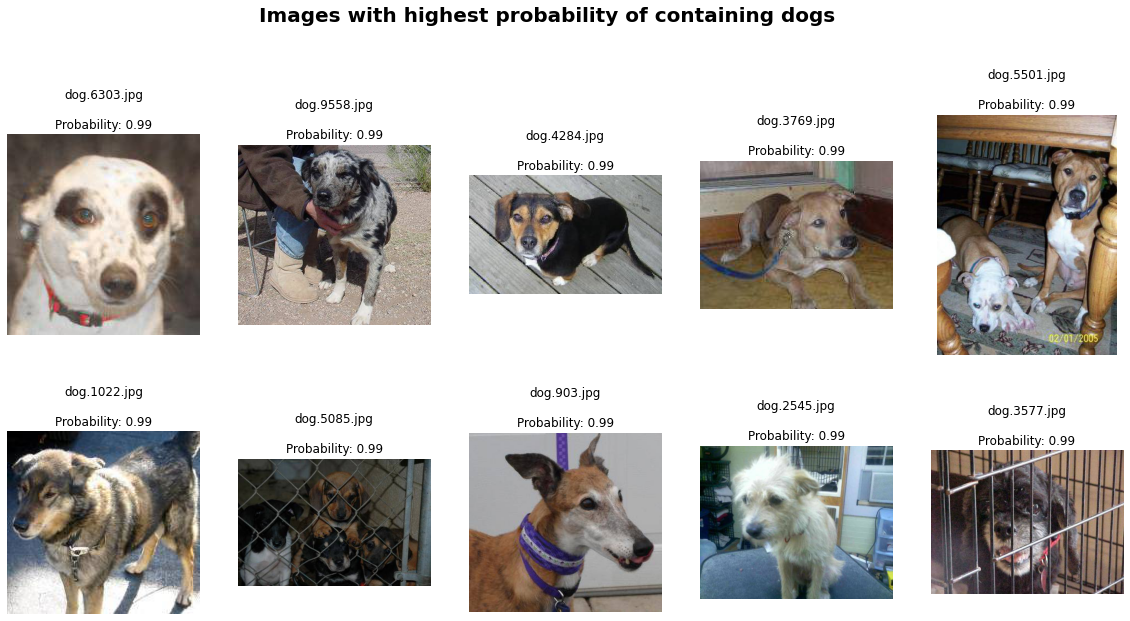

In [0]:
# Most confident predictions of 'dog'
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               False)
message = 'Images with highest probability of containing dogs'
display(most_confident_dog_images, message)

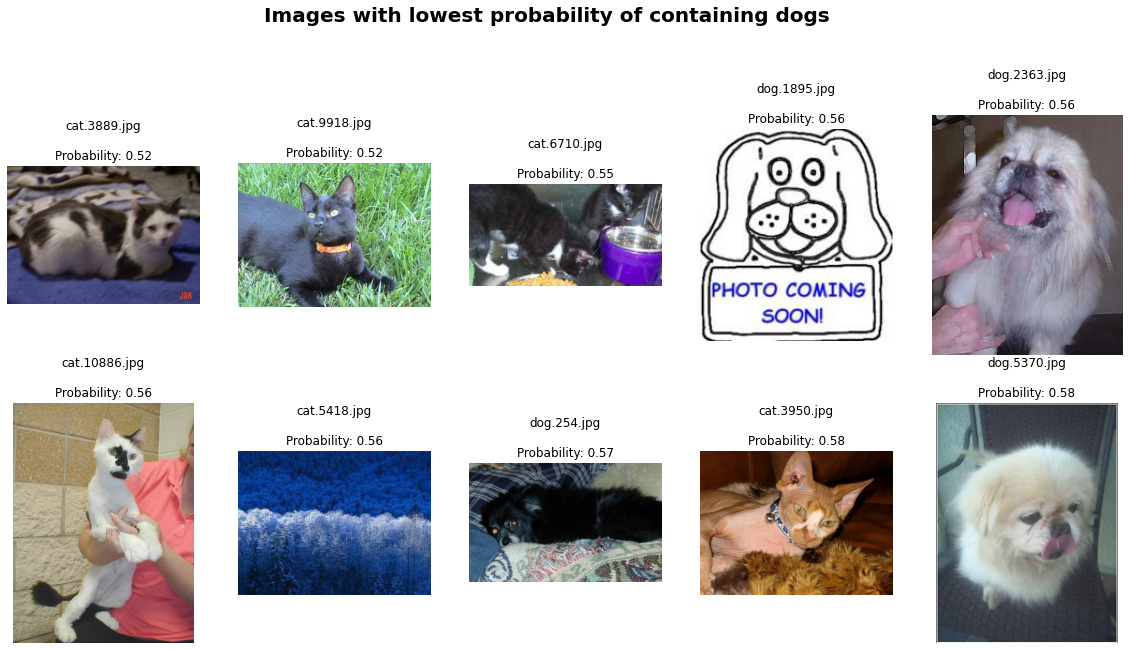

In [0]:
least_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10,
                                               False)
message = 'Images with lowest probability of containing dogs'
display(least_confident_dog_images, message)

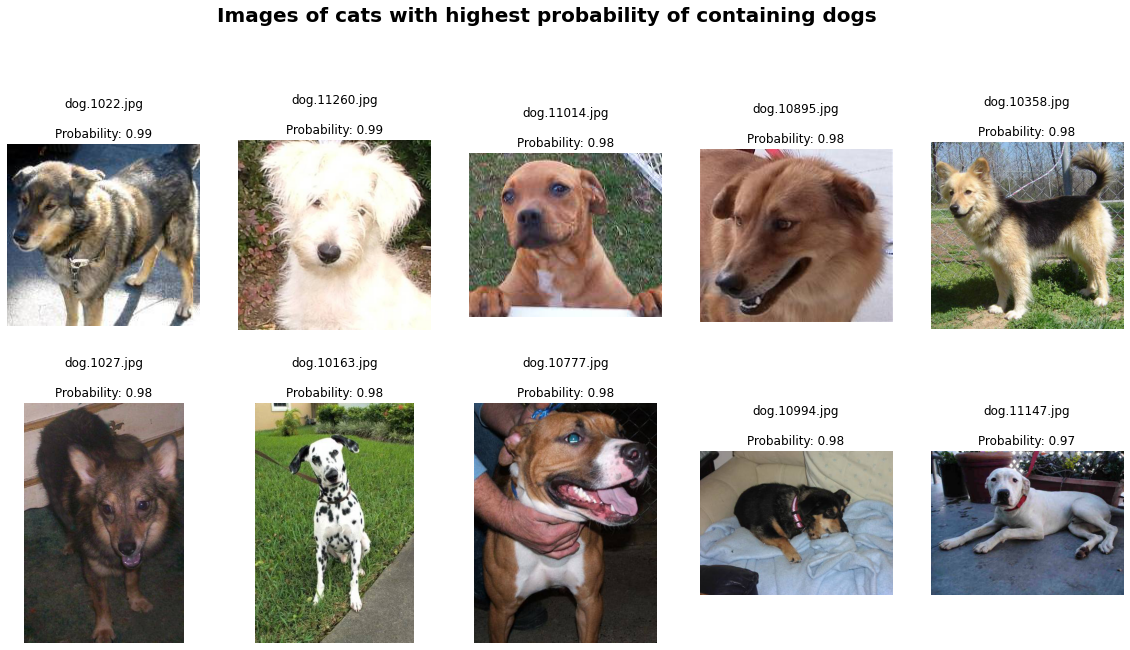

In [0]:
incorrect_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               True)
message = 'Images of cats with highest probability of containing dogs'
display(incorrect_dog_images, message)

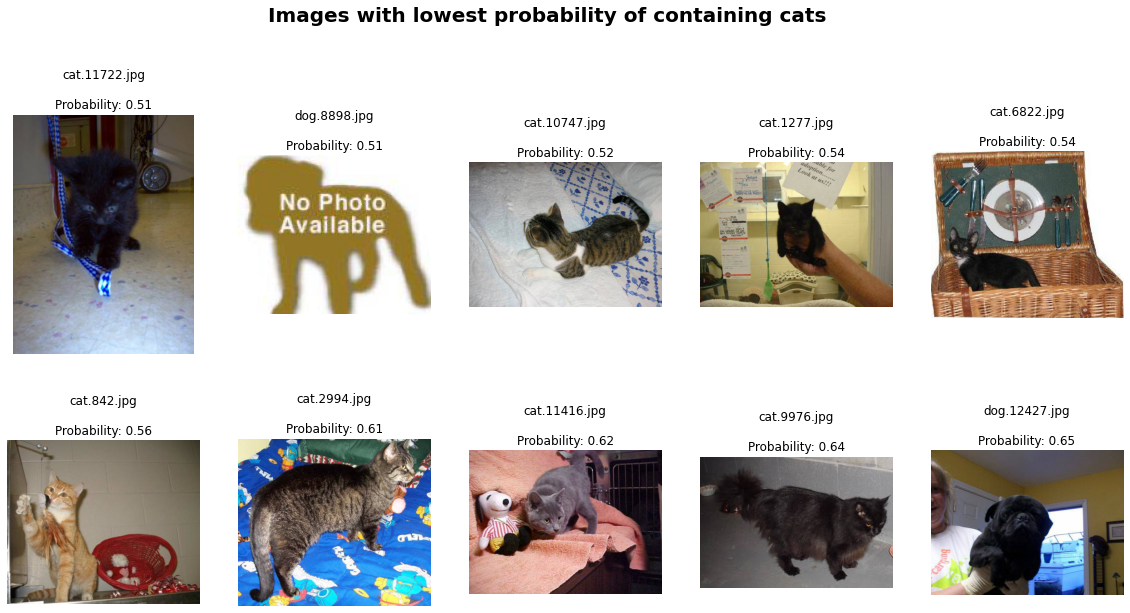

In [0]:
least_confident_cat_images = get_images_with_sorted_probabilities(prediction_table, False, 0, 10,
                                               False)
message = 'Images with lowest probability of containing cats'
display(least_confident_cat_images, message)

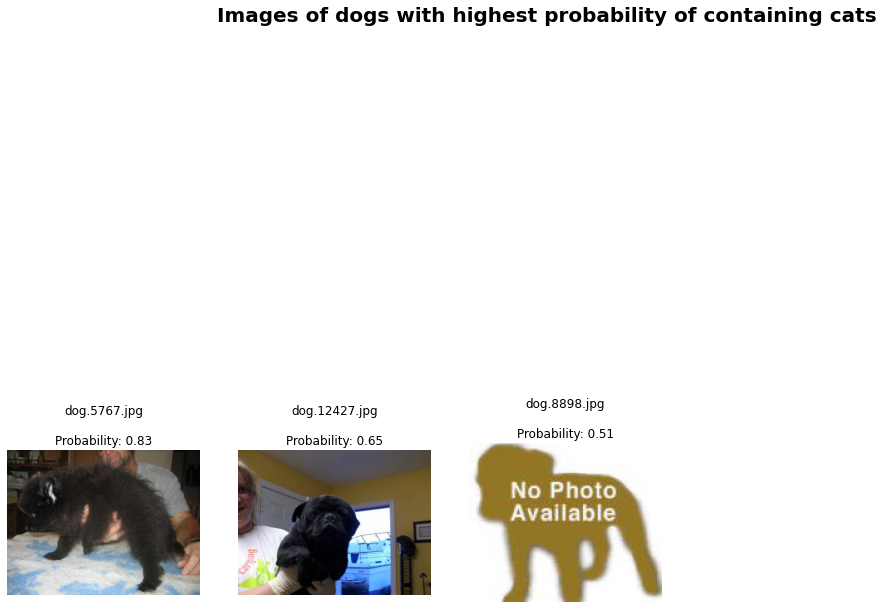

In [0]:
incorrect_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, True)
message = 'Images of dogs with highest probability of containing cats'
display(incorrect_cat_images, message)

In [0]:
indices

In [0]:
ff = validation_generator.filenames
print(len(ff))
print(ff[:10])